# GAM decoding
Decode distance to target using a B-spline to learn filter shapes.


In [8]:
# load  data (requires a pull from the repo to get the pre processing code going)
import sys,os
import numpy as np
from scipy.io import loadmat,savemat
import dill
sys.path.append('/Users/edoardo/Work/Code/GAM_code/GAM_library')
sys.path.append('/Users/edoardo/Work/Code/GAM_code/firefly_utils')
from data_handler import data_handler
from GAM_library import *

# save directory
DIRECT = ''

min_bin_size = 0.01 # min size of a spike count bin in sec


session = 'm53s113'
# path to the .mat dataset
base_file = '/Volumes/WD_Edo/firefly_analysis/LFP_band/DATASET_accel/'
dat = loadmat(os.path.join(base_file,'%s.mat'%(session)))



use_eye = 'right'
exp_data = data_handler(dat, 'trials_behv', 'units', None, 'behv_stats',
                        use_eye=use_eye,extract_fly_and_monkey_xy=True)

exp_data.set_filters('all', True)
exp_data.filter = exp_data.filter + exp_data.info.get_replay(0,skip_not_ok=False)

time_pts, spikes, sm_traj, raw_traj, fly_pos, cov_dict = exp_data.GPFA_YU_preprocessing([('t_targ','t_targ_off',15),('t_targ_off','t_stop',50),('t_stop','t_reward',15)],
                                                                                          var_list=['eye_vert','eye_hori','rad_vel','ang_vel','rad_target','ang_target'])

idx_trial = np.arange(rate.shape[0])

select = exp_data.filter & ((np.diff(time_pts,axis=1) > min_bin_size).prod(axis=1) > 0)

idx_trial = idx_trial[select]
spikes = spikes[select]
time_pts = time_pts[select]
print('SAVING') # matlab file because it will be an input to GPFA matlab code
savemat(os.path.join(DIRECT,'test_%s_gpfa.mat'%session), mdict={'dat': {'spikes':spikes,'timeDiscr':time_pts,'trialId':idx_trial},
                                                                    'sm_trajectory':sm_traj,'raw_trajectory':raw_traj,
                                                                    'fly_pos':fly_pos,'var_struct':cov_dict,'info_trial':exp_data.info.trial_type})

unable to extract pairs, different blocks number
no eyetracking...
['all', 'reward', 'density', 'ptb', 'microstim', 'landmark', 'replay', 'controlgain', 'firefly_fullON']
Succesfully set filter
SAVING


# Import, create model matrix using B-splines, fit

In [14]:
# import some library, create the data_handler object that will generate the b-spline
import matplotlib.pylab as plt
import scipy.linalg as linalg
import scipy.stats as sts

rad_target = cov_dict['rad_target']


# # filter the trials
rad_target = rad_target[idx_trial,:]
# raw_traj = raw_traj[idx_trial,:,:]

# create a GAM stacking the inputs
Y = rad_target.reshape(rad_target.shape[0]*rad_target.shape[1])
trial_id_stacked = np.zeros(Y.shape[0],dtype=int)
cc = 0
for tr in idx_trial:
    trial_id_stacked[cc:cc+rad_target.shape[1]] = tr
    cc += rad_target.shape[1]
X_spk = spikes.transpose([0,2,1]).reshape(spikes.shape[0]*spikes.shape[2],spikes.shape[1])


# loop over units and generate the handler
non_nan = (~np.isnan(Y))

sm_handler = smooths_handler()
knots = np.linspace(-20,20,5)
knots = np.hstack(([knots[0]] * 3,
                   knots,
                   [knots[-1]] * 3
                   ))

is_temporal_kernel = True
kernel_direction = 0


for k in range(X_spk.shape[1]):
    if k%15 == 0:
        print('unit %d'%k)
    sm_handler.add_smooth('neu_%d'%k, [X_spk[non_nan,k]], ord=4, knots=[knots],
                               knots_num=None, perc_out_range=None,
                               is_cyclic=[False], lam=50,
                               penalty_type='der',
                               der=2,
                               trial_idx=trial_id_stacked[non_nan], time_bin=1.,
                               is_temporal_kernel=is_temporal_kernel,
                               kernel_length=20,
                               kernel_direction=kernel_direction, ord_AD=3, ad_knots=4,
                               repeat_extreme_knots=False)




Y = Y[non_nan]
trial_id_stacked = trial_id_stacked[non_nan]

# separate test and train
unq_trials = np.unique(trial_id_stacked)
test_trials = unq_trials[::10]
train_trials = np.array(list(set(unq_trials).difference(set(test_trials))))

bool_train = np.zeros(trial_id_stacked.shape[0],dtype=bool)
for tr in train_trials:
    bool_train[trial_id_stacked==tr] = True
bool_test = ~bool_train

# get the model matrix and the smoothing penalization
X,idx_dict = sm_handler.get_exog_mat(sm_handler.smooths_var)
M = sm_handler.get_penalty_agumented(sm_handler.smooths_var)
Pen = np.dot(M.T,M)
# to change the penalization constant we could set 

# penalized regression (using formula for the estimator, could be unstable...
# SVD based computation would be more robyst)
beta = np.dot(np.linalg.pinv(np.dot(X[bool_train].T,X[bool_train])+Pen),np.dot(X[bool_train].T,Y[bool_train]))


# estimate covariance (not great since the smoothing prior is not estimated)
M = np.array(M, dtype=np.float64)
Q, R = np.linalg.qr(X, 'reduced')
U, s, V_T = linalg.svd(np.vstack((R, M[:, :])))

# remove low val singolar values
i_rem = np.where(s < 10 ** (-8) * s.max())[0]

# remove cols
s = np.delete(s, i_rem, 0)
U = np.delete(U, i_rem, 1)
V_T = np.delete(V_T, i_rem, 0)

# create diag mat
di = np.diag_indices(s.shape[0])
D2inv = np.zeros((s.shape[0], s.shape[0]))
D2inv[di] = 1 / s ** 2
D2inv = np.matrix(D2inv)
V_T = np.matrix(V_T)

cov_beta = np.array(V_T.T * D2inv * V_T)


(52976,) (52976, 81) (688, 81, 77)
unit 0
unit 15
unit 30
unit 45
unit 60
unit 75
hstack: 12.94039708199989 sec
tranform to full matrix:  0.2647489270002552 sec


# Plot some example filters

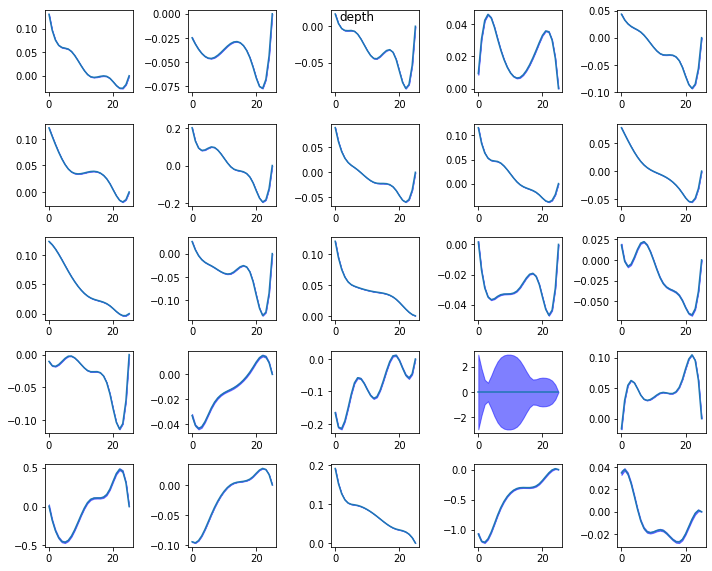

In [16]:
plt.figure(figsize=(10,8))
plt.suptitle('depth')
for k in range(25):
    plt.subplot(5,5,k+1)
    BK = sm_handler.smooths_dict['neu_%d'%k].basis_kernel.toarray()
    func = np.dot(BK[:,:-1], beta[idx_dict['neu_%d'%k]])
    plt.plot(func)
    se_y = np.sqrt(
        np.sum(np.dot(BK[:, :-1], cov_beta[idx_dict['neu_%d' % k], :][:, idx_dict['neu_%d' % k]]) * BK[:, :-1], axis=1))
    norm = sts.norm()
    se_y = se_y * norm.ppf(1 - (1 - 0.95) * 0.5)
    plt.fill_between(range(len(func)),func - se_y,func + se_y,alpha=0.5,color='b')
plt.tight_layout()

# Compute R^2 and example cv-decoded distance to target

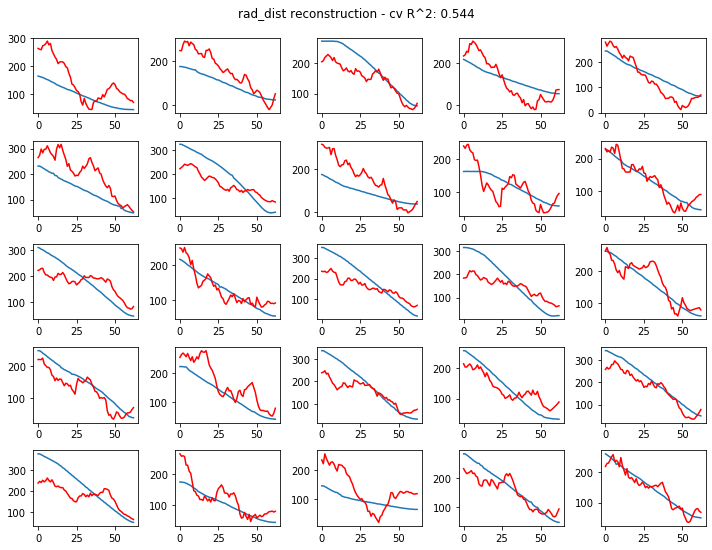

In [20]:
predict = np.dot(X[bool_test],beta)
RSS = np.sum((predict - Y[bool_test])**2)
TSS = np.sum((Y[bool_test] - np.mean(Y[bool_test]))**2)
adj_r2 = 1-(non_nan.sum()-1)/(non_nan.sum() - X.shape[1] - 1) * RSS/TSS

plt.figure(figsize=(10,8))
plt.suptitle('rad_dist reconstruction - cv R^2: %.3f'%adj_r2)

for k in range(25):
    plt.subplot(5,5,k+1)
    tr = test_trials[k]
    sel = trial_id_stacked[bool_test] == tr
    plt.plot(Y[bool_test][sel])
    plt.plot(predict[sel],'r')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

tot trials: 68


Text(0, 0.5, 'R^2')

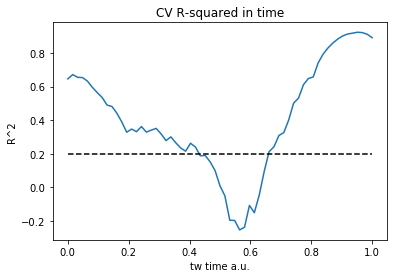

In [56]:
# plot initial distance vs decoded initial distance
unq_test = np.unique(test_trials)
true_dist = np.zeros((unq_test.shape[0],63))*np.nan
dec_dist = np.zeros((unq_test.shape[0],63))*np.nan

for k in range(test_trials.shape[0]):
    
    tr = test_trials[k]
    sel = trial_id_stacked[bool_test] == tr
    
    true_dist[k,:sel.sum()] = Y[bool_test][sel]
    dec_dist[k,:sel.sum()]  = predict[sel]

non_nan = ~np.isnan(true_dist[:,-1])
true_dist = true_dist[non_nan,:]
dec_dist = dec_dist[non_nan,:]
print('tot trials:',true_dist.shape[0])

# plot
RSS = np.sum((dec_dist - true_dist)**2,axis=0)
TSS = np.sum((true_dist - np.mean(true_dist))**2,axis=0)
r2 = 1 - RSS/TSS 
plt.title('CV R-squared in time')
plt.plot(np.linspace(0,1,r2.shape[0]),r2)
plt.plot([0,1],[0.2,0.2],'--k')
plt.xlabel('tw time a.u.')
plt.ylabel('R^2')

tot trials: 606


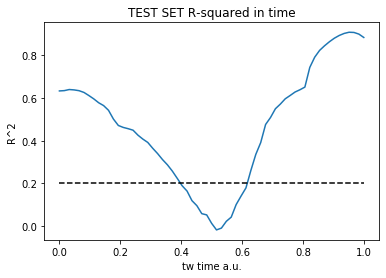

In [57]:
# plot initial distance vs decoded initial distance
predict_train = np.dot(X[bool_train],beta)
unq_train = np.unique(train_trials)
true_dist = np.zeros((unq_train.shape[0],63))*np.nan
dec_dist = np.zeros((unq_train.shape[0],63))*np.nan

for k in range(train_trials.shape[0]):
    
    tr = train_trials[k]
    sel = trial_id_stacked[bool_train] == tr
    
    true_dist[k,:sel.sum()] = Y[bool_train][sel]
    dec_dist[k,:sel.sum()]  = predict_train[sel]

non_nan = ~np.isnan(true_dist[:,-1])
true_dist = true_dist[non_nan,:]
dec_dist = dec_dist[non_nan,:]
print('tot trials:',true_dist.shape[0])

# plot
RSS = np.sum((dec_dist - true_dist)**2,axis=0)
TSS = np.sum((true_dist - np.mean(true_dist))**2,axis=0)
r2 = 1 - RSS/TSS 
plt.title('TEST SET R-squared in time')
plt.plot(np.linspace(0,1,r2.shape[0]),r2)
plt.xlabel('tw time a.u.')
plt.ylabel('R^2')
plt.plot([0,1],[0.2,0.2],'--k')

